In this project I will be looking at data relating to one of my favourite british shows, Dragon's Den,                           scraped from https://www.tigermobiles.com/dragons-den/

I answer the following questions:
<ul>
    <li> How many companies are still in business ?</li>
    <li> How many investemnts went through ?</li>
    <li> Who are the most active investers ?</li>
    <li> What is the average amount of money invested ? How about the average % of equity shared ? </li>
    </ul>

Further investigation could look into:
<ul>
    <li> How well have the companies done after appearing on the show ?</li>
    <li> What field is most common appearing on the show/ most likely to earn an investment ?</li>


In [1]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import pandas as pd
import re
from pandas import Series, DataFrame
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline


In [2]:
url = 'https://www.tigermobiles.com/dragons-den/'

In [3]:
uClient = uReq(url) #openning up a connection, grabbing the page

In [4]:
page_html = uClient.read() #offloads the content into a variable
uClient.close() #close the file

In [5]:
page_soup = soup(page_html, 'lxml') # #the text needs to be parsed (as we have the raw html at the moment)

In [6]:
columns = page_soup.find('div', {'class': 'cols all-items'})#the part of the webpage containing a column of all companies

In [7]:
companies_info = columns.find_all('div',{'class':'dd-item-desc'})#a list of info for all individual companies

In [8]:
#Required data is:
#company name: h2
#investor name : div class 'dd-profile'
#series
#ivestment amount
#equity bought
#did the investment go through ?
#is the company still in bussiness ?

#In the future, could get the other data such as incorporation date as well

In [9]:
company_names = []
investors_list = []
show_series = []
investment_amount = []
equity_shared = []
investment_went_trhough = []
company_still_in_business = []


for company in companies_info:
    
    company_name = company.find('h2').text
    company_names.append(company_name)
    
    
    investors = company.find_all('div',{'class': 'dd-profile'})# there can be more than one investor
    # the name is in the form of 'FistLast', so to make it look better it's changed to 'First Last'
    investors_names =[]
    for investor in investors:
        investor = investor.text
        first_and_last = re.sub( r"([A-Z])", r" \1", investor).split()#split on capital letter
        investor_name = ' '.join(first_and_last)#join the names back into a string with a space between them
        investors_names.append(investor_name)
    investors_list.append(investors_names)
    
    
    # the last three h4 elements are the show's Series number, the investment amount and the equity% purchased
    details = company.find_all('span')[1:]#the first one is the names of the people appearing on the show
    series = details[0].text
    show_series.append(series)
    investment = details[1].text
    investment_amount.append(investment)
    equity = details[2].text
    equity_shared.append(equity)
    
    
    # the first two 'one-half' class divs are info on what happened after the show
    follow_up = company.find_all('div', {'class':'one-half'})[:2]

    #the answer to the question is in the form of an image with a specific div.
    icon_yes_0 = follow_up[0].find('div',{'class':'icon-yes'})# if the icon is no, the outpout is None

    if icon_yes_0:
        went_through ='Yes'
    else:
        went_through = 'No' 
    investment_went_trhough.append(went_through)

    icon_yes_1 = follow_up[1].find('div',{'class':'icon-yes'})

    if icon_yes_1:
        still_in_business ='Yes'
    else:
        still_in_business = 'No' 
    company_still_in_business.append(still_in_business)

In [158]:
df = DataFrame(list(zip(company_names,investors_list, show_series, investment_amount, 
                        equity_shared, investment_went_trhough, company_still_in_business)),
              columns =['company_name', 'investors_names', 'series','investment','equity','went_through','still_in_business'])

In [159]:
df.head()

,company_name,investors_names,series,investment,equity,went_through,still_in_business
0,Oatein Ltd,[Peter Jones],16,"£50,000",25%,No,Yes
1,Buddies Toothpaste,[],16,"£60,000",44%,No,Yes
2,Didsbury Gin,[Jenny Campbell],16,"£75,000",33%,Yes,Yes
3,Van De Sant Innovations,[Deborah Meaden],16,"£70,000",15%,No,Yes
4,OHMME,[Peter Jones],16,"£80,000",20%,No,Yes


investment and equity columns need to be changed to a number type

In [12]:
for i, amount in enumerate(df['investment']):    
    price_num = []
    for char in amount:
        if char.isalnum():#create a list without the '£' and ','
            price_num.append(char)
    price = ''.join(price_num)#rejoin the numbers in a string
    df['investment'][i] = int(price)#change the current investment value to the integer of the amount

In [13]:
for i, eq in enumerate(df['equity']):
    df['equity'][i] = float(eq[:-1])

In [14]:
#in order to easily obtain a histogram which shows the series numbers in order, the type is converted from str to int

#there is an empty string value in the series list. As the rows next and before it are season 11, it'll be assumed that the '' 
#corresponds to 11
for i, ser in enumerate(df['series']):
    if ser =='':
        df['series'][i]=11
    
    else:
        df['series'][i]=str(ser)


In [15]:
df.head()

,company_name,investors_names,series,investment,equity,went_through,still_in_business
0,Oatein Ltd,[Peter Jones],16,50000,25,No,Yes
1,Buddies Toothpaste,[],16,60000,44,No,Yes
2,Didsbury Gin,[Jenny Campbell],16,75000,33,Yes,Yes
3,Van De Sant Innovations,[Deborah Meaden],16,70000,15,No,Yes
4,OHMME,[Peter Jones],16,80000,20,No,Yes


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


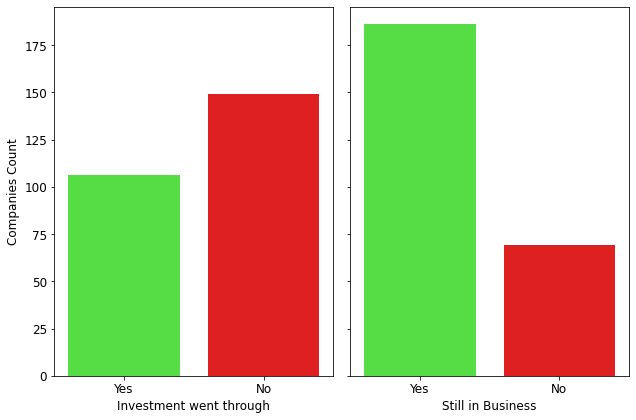

In [16]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

f, axes = plt.subplots(1, 2, figsize=(9, 6), sharey = True)

ax1 = sns.countplot('went_through', data=df, palette = ["#43f52c", "#ff0000"], ax = axes[0], order=["Yes","No"])
ax1.set(xlabel='Investment went through', ylabel='Companies Count')

ax2 = sns.countplot('still_in_business', data=df, palette =["#43f52c", "#ff0000"], ax =axes[1])
ax2.set(xlabel='Still in Business', ylabel='')


plt.setp(axes, yticks=[0,25,50, 75, 100, 125, 150, 175])
plt.tight_layout()

In [71]:
def investment_histogram(dataframe_, coords):

    #fig, ax  = plt.subplots()
    ax_invest = sns.distplot(dataframe_['investment'], kde_kws = {'color': 'k'},
                hist_kws = {'color':'green', 'alpha': 1}, ax = coords)#plot a histogram and a kernel density estimation
    ax_invest.set_xlabel('Dollars')
     
    #code below deals with ticks positions and formating
    ax_invest.xaxis.set_ticks_position('bottom')
    ax_invest.yaxis.set_ticks_position('left')
    ax_invest.set_xlim(0,275000)

    ax_invest.tick_params(which='major', width=1.00, length=5)
    ax_invest.tick_params(which='minor', width=0.75, length=2.5)
    ax_invest.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
    ax_invest.xaxis.set_major_locator(ticker.MultipleLocator(50000))  
    
    ax_invest.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))#change x axis labels format from '10000' to '10,000'

In [72]:
def equity_histogram(dataframe_, coords):

    ax_equity = sns.distplot(dataframe_['equity'], kde_kws = {'color': 'k'},
                hist_kws = {'color':'b', 'alpha': 1}, ax = coords)#plot a histogram and a kernel density estimation
    ax_equity.set_xlabel('Equity')
    
    #code below deals with ticks positions and formating
    ax_equity.xaxis.set_ticks_position('bottom')
    ax_equity.yaxis.set_ticks_position('left')
    ax_equity.set_xlim(0,85)
    
    ax_equity.tick_params(which='major', width=1.00, length=5)
    ax_equity.tick_params(which='minor', width=0.75, length=2.5)
    ax_equity.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax_equity.xaxis.set_major_locator(ticker.MultipleLocator(10))
    
    ax_equity.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))# make x axis labels show % sign

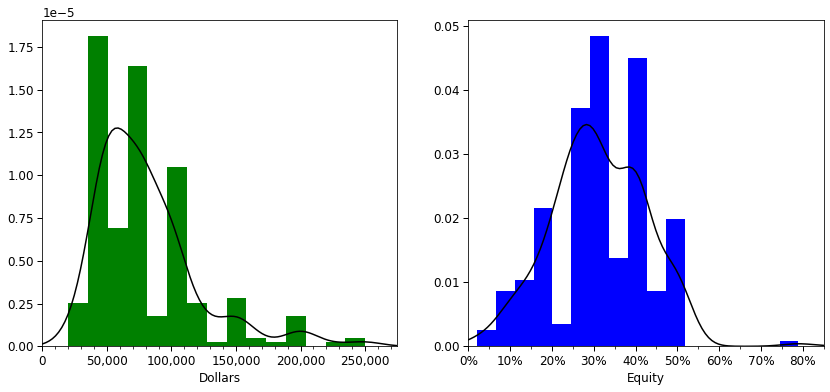

In [73]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))

investment_histogram(df, axes[0])
equity_histogram(df,axes[1])

In [74]:
df_invested = df[df.went_through == 'Yes'] # create a new data frame only containing data for investments that went through

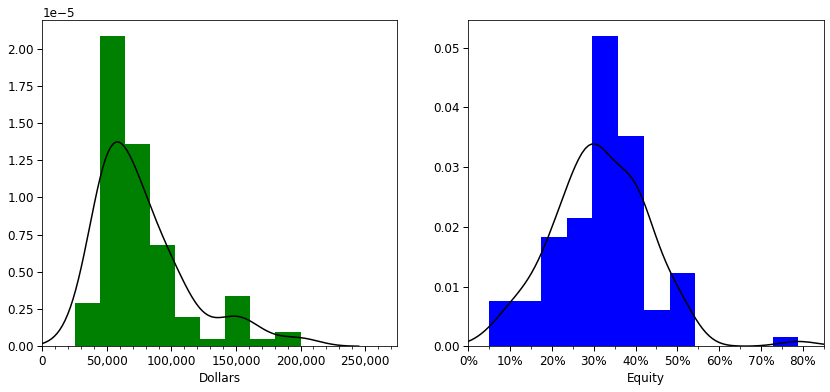

In [75]:
f, axes = plt.subplots(1, 2, figsize=(14, 6))


investment_histogram(df_invested, axes[0])
equity_histogram(df_invested, axes[1])

In [41]:
#in order to plot the series in ascending order:
seasons = list(set(df['series'].tolist()))#get a list of all seasons
seasons = [int(season) for season in seasons]#turn to integer for sorting
seasons.sort(reverse = False)
seasons =[str(season) for season in seasons] #turn back to string

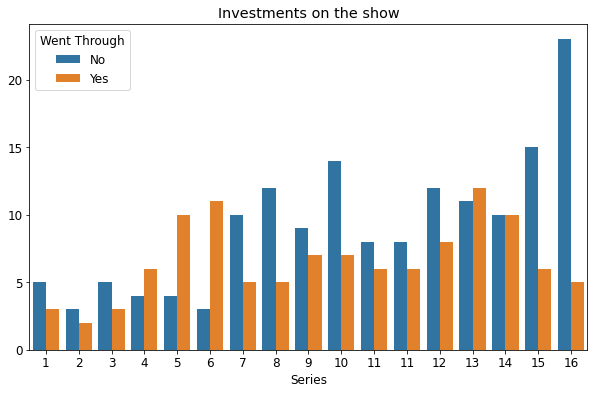

In [82]:
figure(figsize = (10,6))
f = sns.countplot('series', data=df, order = seasons, hue = 'went_through')
f.set_title('Investments on the show')
f.set_xlabel('Series')
f.set_ylabel('')
f.legend_.set_title('Went Through')
plt.close()
f.figure


In [84]:
names_list = df['investors_names'].tolist()#currently a list of lists of investors for each company

#just a list of investors, which appear each time they were invested:
flat_list = [investor for company in names_list for investor in company]

In [146]:
#changing the names to appear shorter:
shortened_names = []
for n in flat_list:
    names = n.split(' ')
    names[0] = names[0][0]
    fin = '. '.join(names)
    shortened_names.append(fin)
    

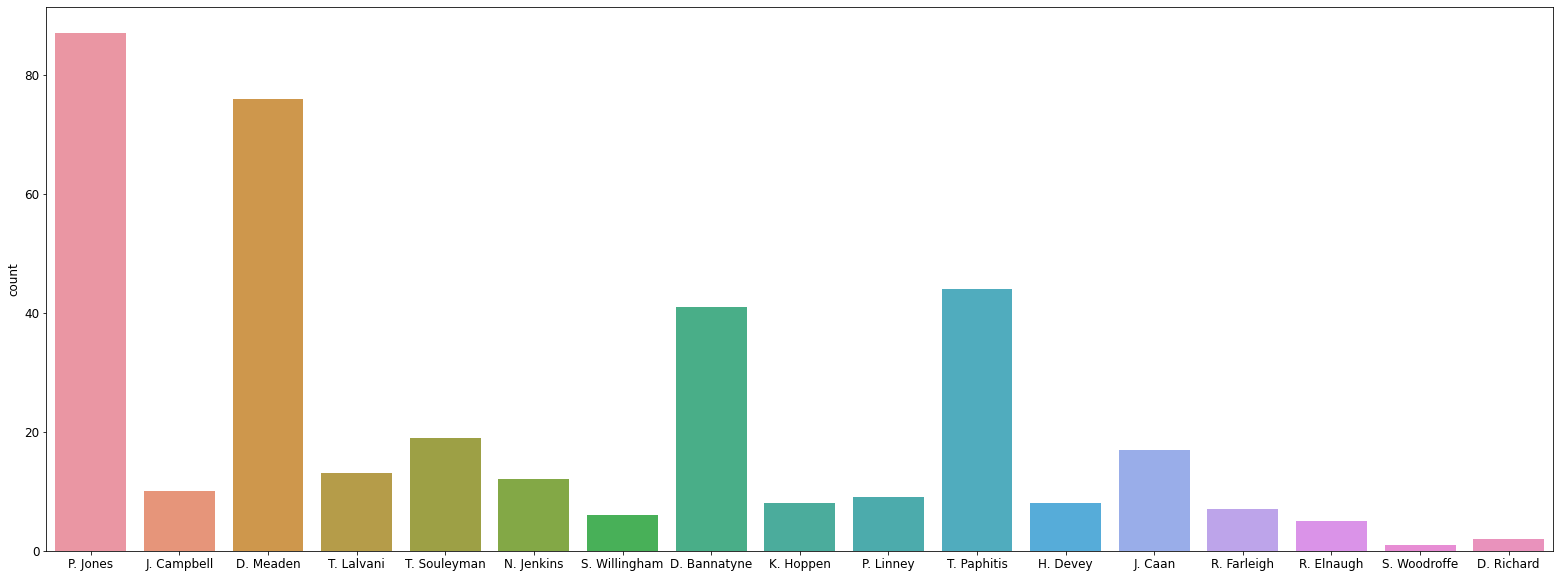

In [166]:
plt.figure(figsize=(27,10))
sns.countplot(shortened_names)
plt.show()

These are plots containing only the investments that went through. While there may be one or two exceptions where the exact equity agreed upon originally was slightly modified in the after-show negociations, for the most part it stayed the same.

There seems to be a decrease in the trend of % deals that go through after the show appearnce

In [152]:
names_list_invested = df_invested['investors_names'].tolist()#currently a list of lists of investors for each company

flat_list_invested = [investor for company in names_list for investor in company]#just a list of investors, which appear each time they
#were invested

In [164]:
shortened_names_invested = []
for n in flat_list:
    names = n.split(' ')
    names[0] = names[0][0]
    fin = '. '.join(names)
    shortened_names_invested.append(fin)

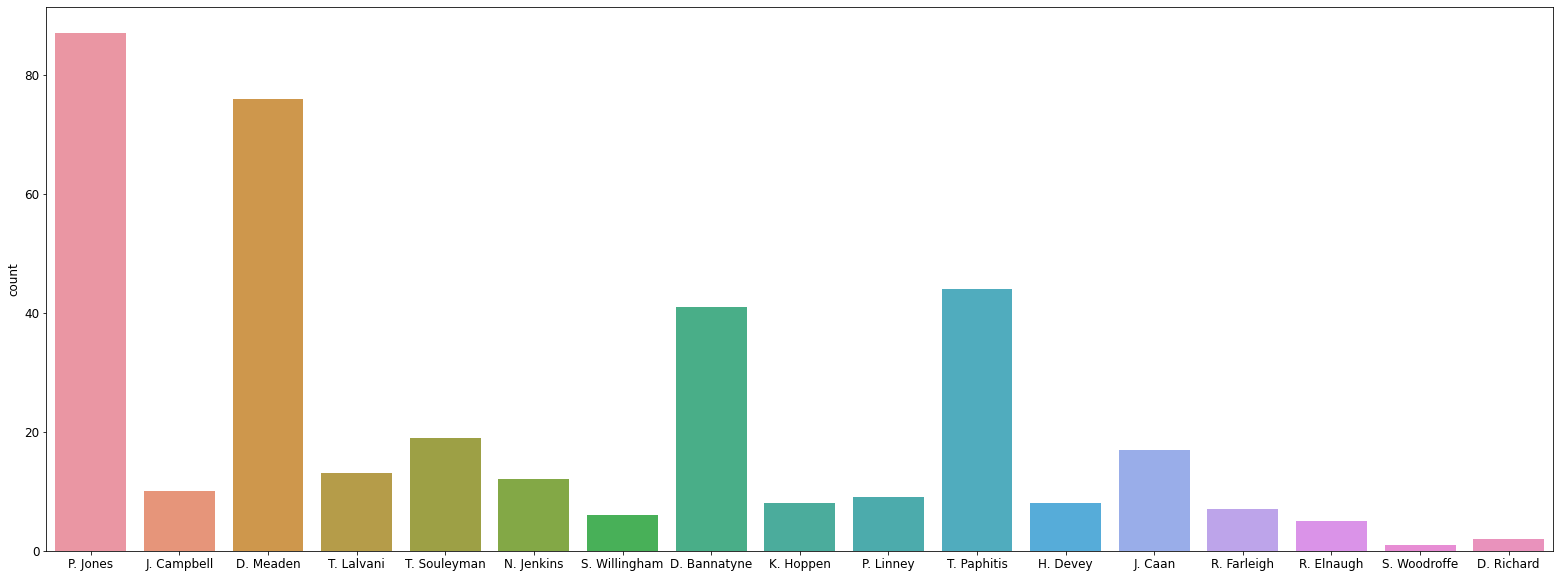

In [167]:
plt.figure(figsize=(27,10))
sns.countplot(shortened_names_invested)
plt.show()

In [ ]:
#compare to number of contestants/episodes per season

#look only at investments that went through: how many deals per season or per episode for each dragon ? 
#how much money invested ?